<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data Visualization</center>

# Challenge S3: Prophet 
# Planificación de escenarios a futuro post-confinamiento en Retail

Tenemos las ventas de todas las tiendas de una cadena de retail en una serie de categorías desde principios de 2018 hasta que acabó el confinamiento estricto y queremos hacer un análisis del impacto que ha tenido en las distintas categorías y plantear escenarios a futuro en caso de haber alguna vuelta al confinamiento.

Teniendo esta valiosa información podríamos mejorar el stockage de los productos de las distintas categorías y poder reaccionar rápido en cuanto se anunciasen las nuevas medidas para poder amoldar espacios en los distintos almacenes de las tiendas y los pedidos en las distintas categorías en base a los distintos escenarios que podamos proponer.

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Cargar las ventas en un DataFrame

In [2]:
df_datos_categorias = pd.read_csv('Tabla Ventas Cats.csv',delimiter = ';')
df_datos_categorias['Fecha'] = pd.to_datetime(df_datos_categorias['Fecha'], format='%Y-%m-%d')
df_datos_categorias.tail()

,Fecha,Categoría,Unidades,Ventas
14865,2020-05-31,Yogurt saludable,4.000,8.56
14866,2020-05-31,Papel higiénico,3.000,8.99
14867,2020-05-31,Patatas,2.000,7.18
14868,2020-05-31,Naranjas,9.475,25.25
14869,2020-05-31,Tabletas de chocolate,7.000,8.96


In [3]:
df_datos_categorias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14870 entries, 0 to 14869
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha      14870 non-null  datetime64[ns]
 1   Categoría  14870 non-null  object        
 2   Unidades   14870 non-null  float64       
 3   Ventas     14870 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 464.8+ KB


## 2. Exploración de los datos

** P. ¿ Cuál es el inicio y el final de datos ? **

In [4]:
#Los datos pertenecen a una serie temporal diaria, que se represena en la columna fecha
print('El inicio de los datos es : ',str(df_datos_categorias['Fecha'].describe(datetime_is_numeric=True).loc['min']))
print('El final de los datos es : ',str(df_datos_categorias['Fecha'].describe(datetime_is_numeric=True).loc['max']))

El inicio de los datos es :  2018-01-01 00:00:00
El final de los datos es :  2020-05-31 00:00:00


** P ¿ De qué categorías tenemos venta ? **

In [5]:
cats = df_datos_categorias['Categoría'].unique()
print('Las categorias de productos son : ',str(cats))

Las categorias de productos son :  ['Aguas sin gas' 'Cervezas con alcohol' 'Colas' 'Utensilios de cocina'
 'Frutos secos' 'Leche' 'Huevos' 'Pizza congelada' 'Pasta'
 'Caldos y cremas líquidas' 'Yogurt saludable' 'Barras de pan baguette'
 'Barras de pan rústico' 'Papel higiénico' 'Patatas' 'Naranjas'
 'Tabletas de chocolate']


## 3. Obtención de la mejor y peor categoría en los distintos trimestres y lo que llevamos de semestre

Vamos a obtener un dataframe con el comportamiento de las distintas categorías en cuanto a variación porcentual de ventas para el Q1, Q2 y lo que llevamos de S1, es decir hasta el 31 de Mayo.

%Var = ((Vactuales/Vanteriores) - 1 ) * 100

In [6]:
#Función que aplica la formula de la variación de las ventas.
def calculo_variaciones (column):
    resultado = ((column/column.shift(1))-1)*100 
    return resultado

In [7]:
# Lo primero que realizamos es establecer el campo fecha como indice para poder trabajar de forma más optima con el
df_categorias_trimestre = df_datos_categorias.copy()
#df_categorias_trimestre = df_categorias_trimestre[df_categorias_trimestre['Fecha']>='2020']
df_categorias_trimestre

,Fecha,Categoría,Unidades,Ventas
0,2018-01-01,Aguas sin gas,14.000,7.00
1,2018-01-01,Cervezas con alcohol,68.000,45.66
2,2018-01-01,Colas,24.000,26.14
3,2018-01-01,Utensilios de cocina,36.000,1.91
4,2018-01-01,Frutos secos,10.000,13.70
...,...,...,...,...
14865,2020-05-31,Yogurt saludable,4.000,8.56
14866,2020-05-31,Papel higiénico,3.000,8.99
14867,2020-05-31,Patatas,2.000,7.18
14868,2020-05-31,Naranjas,9.475,25.25


In [8]:
df_categorias_trimestre_pivot = pd.pivot_table(df_categorias_trimestre, values='Ventas', index=['Fecha'],
                     columns=['Categoría'],aggfunc='sum',fill_value=0)
df_categorias_trimestre_pivot=df_categorias_trimestre_pivot.resample('Q').sum()
#df_categorias_trimestre_pivot.pct_change()
df_categorias_trimestre_pivot=df_categorias_trimestre_pivot.apply(calculo_variaciones)
df_categorias_trimestre_pivot

Categoría,Aguas sin gas,Barras de pan baguette,Barras de pan rústico,Caldos y cremas líquidas,Cervezas con alcohol,Colas,Frutos secos,Huevos,Leche,Naranjas,Papel higiénico,Pasta,Patatas,Pizza congelada,Tabletas de chocolate,Utensilios de cocina,Yogurt saludable
Fecha,,,,,,,,,,,,,,,,,
2018-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-30,14.187273,-3.879615,-2.054091,-27.178976,17.797694,7.874662,-4.044877,-3.208291,-5.858891,-10.912314,3.003107,-12.990025,4.625274,-5.998381,-3.445385,-1.248278,-2.781414
2018-09-30,15.537725,0.836086,10.426298,-9.794888,24.286446,17.064857,-8.328014,6.121345,-4.488810,-45.590627,-1.352738,-8.597476,14.034509,-8.157561,-13.793104,3.963003,-4.959799
2018-12-31,-18.862237,-3.068667,8.666103,72.171582,-21.486855,-11.390658,27.529403,4.324532,16.752392,58.232827,7.661483,45.973034,12.381564,16.581929,21.606287,7.070311,6.900441
2019-03-31,5.753988,0.564263,-2.636689,-9.890431,-3.499851,-6.706037,-2.491035,-3.399292,-1.463130,20.415935,3.674880,-10.760783,-1.280480,7.954860,3.481384,-10.577510,3.048863
2019-06-30,8.911437,-5.688034,-5.850810,-20.283771,16.983740,9.897520,-3.631239,2.434170,-6.267616,-12.044920,-1.197536,-12.203503,10.616814,-11.613067,-0.523923,17.070794,-1.655429
2019-09-30,16.403533,3.740416,7.197228,-12.188919,22.626831,15.540270,-7.592919,5.571364,-2.690200,-41.127378,-0.301333,-5.602296,-6.453227,-5.405563,-16.139173,39.423413,-2.287937
2019-12-31,-22.215160,-7.478866,4.097710,67.433650,-21.479299,-11.815138,17.533934,4.255773,12.292290,44.928736,5.490355,40.406715,2.152977,13.283605,16.959858,2.667744,2.974253
2020-03-31,13.954956,1.991357,1.339704,8.965703,6.182589,1.044351,17.220868,13.701968,12.371747,72.164658,35.542958,10.415321,18.906869,17.683433,22.286661,-1.170291,14.763495


In [9]:
df_categorias_trimestre_definitivo=df_categorias_trimestre_pivot.T
df_categorias_trimestre_definitivo

Fecha,2018-03-31,2018-06-30,2018-09-30,2018-12-31,2019-03-31,2019-06-30,2019-09-30,2019-12-31,2020-03-31,2020-06-30
Categoría,,,,,,,,,,
Aguas sin gas,NaN,14.187273,15.537725,-18.862237,5.753988,8.911437,16.403533,-22.215160,13.954956,-32.103722
Barras de pan baguette,NaN,-3.879615,0.836086,-3.068667,0.564263,-5.688034,3.740416,-7.478866,1.991357,-51.315834
Barras de pan rústico,NaN,-2.054091,10.426298,8.666103,-2.636689,-5.850810,7.197228,4.097710,1.339704,-43.374503
Caldos y cremas líquidas,NaN,-27.178976,-9.794888,72.171582,-9.890431,-20.283771,-12.188919,67.433650,8.965703,-44.094485
Cervezas con alcohol,NaN,17.797694,24.286446,-21.486855,-3.499851,16.983740,22.626831,-21.479299,6.182589,-3.982569
Colas,NaN,7.874662,17.064857,-11.390658,-6.706037,9.897520,15.540270,-11.815138,1.044351,-22.674900
Frutos secos,NaN,-4.044877,-8.328014,27.529403,-2.491035,-3.631239,-7.592919,17.533934,17.220868,-16.240684
Huevos,NaN,-3.208291,6.121345,4.324532,-3.399292,2.434170,5.571364,4.255773,13.701968,-22.618290
Leche,NaN,-5.858891,-4.488810,16.752392,-1.463130,-6.267616,-2.690200,12.292290,12.371747,-32.540785


In [10]:
#df_categorias_trimestre_definitivo=df_categorias_trimestre_pivot
df_categorias_trimestre_definitivo['T_18']=df_categorias_trimestre_definitivo.iloc[:,1]
df_categorias_trimestre_definitivo['T_19']=df_categorias_trimestre_definitivo.iloc[:,5]
df_categorias_trimestre_definitivo['S_20']=df_categorias_trimestre_definitivo.iloc[:,9]
df_categorias_trimestre_definitivo=df_categorias_trimestre_definitivo.loc[:,['T_18','T_19','S_20']]
df_categorias_trimestre_definitivo.sort_values(by='S_20', ascending=False)


Fecha,T_18,T_19,S_20
Categoría,,,
Naranjas,-10.912314,-12.044920,9.224850
Cervezas con alcohol,17.797694,16.983740,-3.982569
Frutos secos,-4.044877,-3.631239,-16.240684
Tabletas de chocolate,-3.445385,-0.523923,-16.714987
Huevos,-3.208291,2.434170,-22.618290
Colas,7.874662,9.897520,-22.674900
Patatas,4.625274,10.616814,-24.076928
Yogurt saludable,-2.781414,-1.655429,-30.427377
Aguas sin gas,14.187273,8.911437,-32.103722


## 4. Visualización de mejor y peor categoría en el S1

En función a la mejor y peor categoría en cuanto a % de variación de ventas que hayas obtenido en el apartado anterior, haz un ploteo de ambas categorías filtradas para ver cómo ha sido visualmente ese impacto y que veamos que puntos hay interesantes.

En primer lugar sería interesante plotear el primer año de ventas para ver la estacionalidad que tenía o el comportamiento normal de esta serie temporal por así decirlo y luego vamos a ver el comportamiento en lo que llevamos de 2020 para identificar anomalías.

#### Mejor categoría

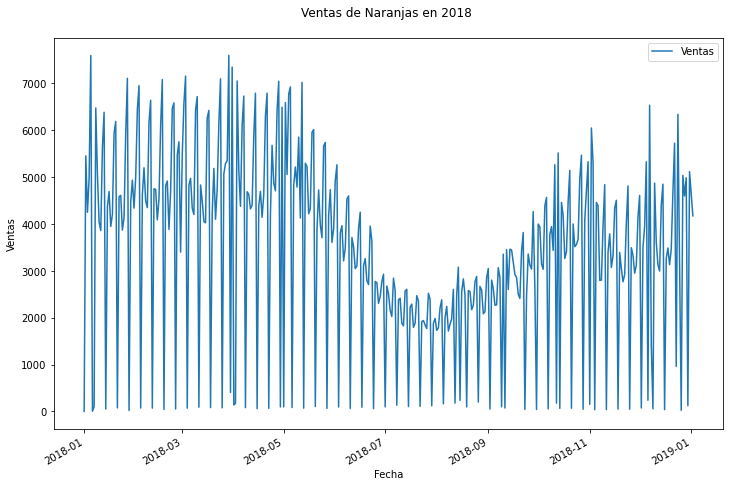

In [11]:
## Representamos nuestra serie temporal para el primer año
df_datos_categorias_mejor=df_datos_categorias[df_datos_categorias['Categoría']=='Naranjas'].loc[:,['Fecha','Ventas']].reset_index(drop=True)
ax = df_datos_categorias_mejor.iloc[:364].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Naranjas en 2018 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

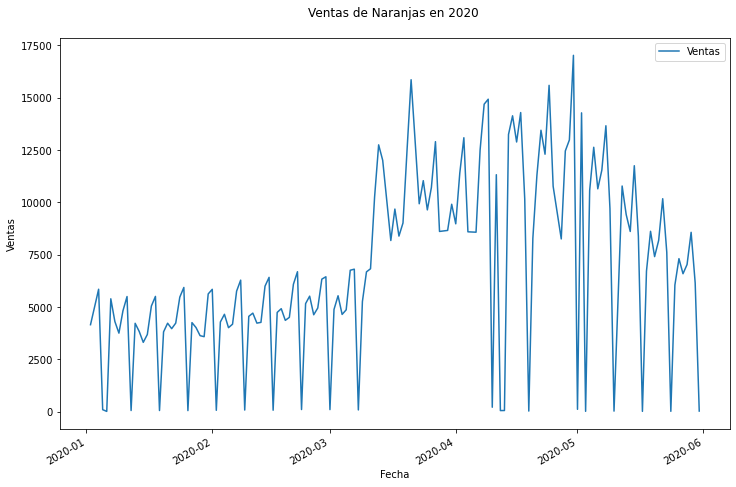

In [12]:
## Representamos nuestra serie temporal para 2020
ax = df_datos_categorias_mejor.iloc[726:].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Naranjas en 2020 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()


#### Peor categoría

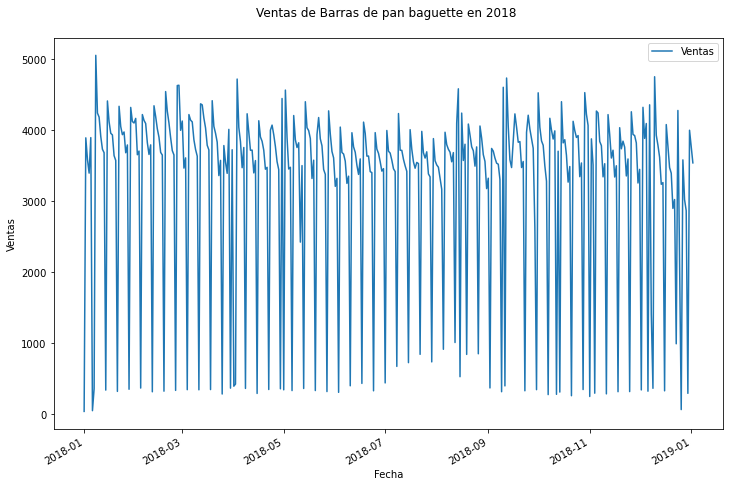

In [13]:
## Representamos nuestra serie temporal para el primer año
df_datos_categorias_peor=df_datos_categorias[df_datos_categorias['Categoría']=='Barras de pan baguette'].loc[:,['Fecha','Ventas']].reset_index(drop=True)
ax = df_datos_categorias_peor.iloc[:364].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Barras de pan baguette en 2018 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

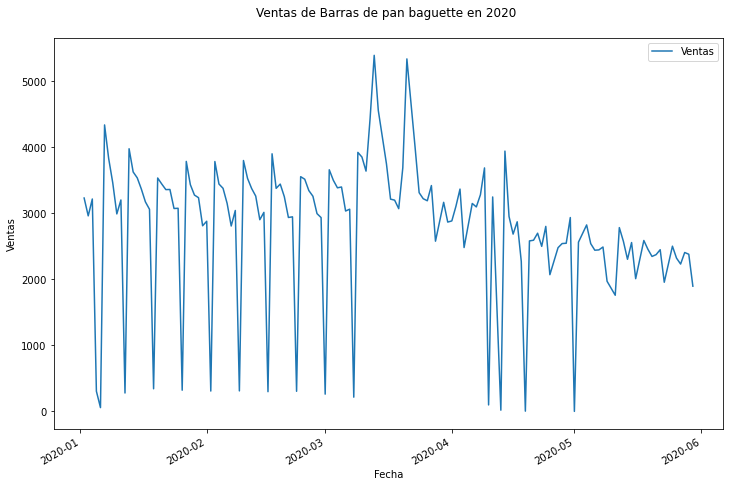

In [14]:
## Representamos nuestra serie temporal para 2020
ax = df_datos_categorias_peor.iloc[726:].set_index('Fecha').plot(figsize = (12, 8),
                                      title = 'Ventas de Barras de pan baguette en 2020 \n')
ax.set_ylabel('Ventas')
ax.set_xlabel('Fecha')

plt.show()

## 5. Realizar una previsión simple sobre las ventas en 2021

En este primer paso se trata de realizar una primera predicción de las ventas de una categoría en concreto hasta el final de 2021, vamos a ver como reacciona el modelo sin añadir ningún tipo de holiday para ver la interpretación del mismo cuando no le damos ningún otro tipo de input.

Para una primera aproximación vamos a coger la categoría con mejor evolución de ventas.

In [15]:
#Preparamos el dataframe para Prophet
df_datos_categorias_mejor = df_datos_categorias_mejor.rename(columns={'Fecha': 'ds', 'Ventas': 'y'})
df_datos_categorias_mejor

,ds,y
0,2018-01-01,1.890000
1,2018-01-02,5454.980826
2,2018-01-03,4249.981477
3,2018-01-04,4981.092628
4,2018-01-05,7594.093859
...,...,...
867,2020-05-27,6586.670017
868,2020-05-28,7026.790011
869,2020-05-29,8565.650021
870,2020-05-30,6147.320011


In [16]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(df_datos_categorias_mejor)
futuro = modelo.make_future_dataframe(periods=214)
futuro.tail()

,ds
1081,2020-12-27
1082,2020-12-28
1083,2020-12-29
1084,2020-12-30
1085,2020-12-31


In [17]:
prevision = modelo.predict(futuro)
prevision.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1081,2020-12-27,9684.025695,6922.016140,10874.220192,9214.116003,10160.948417,-841.892918,-841.892918,-841.892918,2897.5089,...,-3675.027602,-3675.027602,-3675.027602,-64.374215,-64.374215,-64.374215,0.0,0.0,0.0,8842.132777
1082,2020-12-28,9707.469777,10708.801105,14600.445152,9231.313831,10187.625946,2973.061811,2973.061811,2973.061811,2897.5089,...,115.191173,115.191173,115.191173,-39.638262,-39.638262,-39.638262,0.0,0.0,0.0,12680.531588
1083,2020-12-29,9730.913859,11223.173975,15195.230741,9249.410601,10214.156321,3481.500770,3481.500770,3481.500770,2897.5089,...,598.619436,598.619436,598.619436,-14.627566,-14.627566,-14.627566,0.0,0.0,0.0,13212.414629
1084,2020-12-30,9754.357941,10770.562012,14684.859696,9268.842910,10240.603260,3000.990200,3000.990200,3000.990200,2897.5089,...,93.222278,93.222278,93.222278,10.259021,10.259021,10.259021,0.0,0.0,0.0,12755.348140
1085,2020-12-31,9777.802022,11062.465789,15265.835408,9288.502121,10267.050199,3235.331584,3235.331584,3235.331584,2897.5089,...,303.195128,303.195128,303.195128,34.627555,34.627555,34.627555,0.0,0.0,0.0,13013.133606


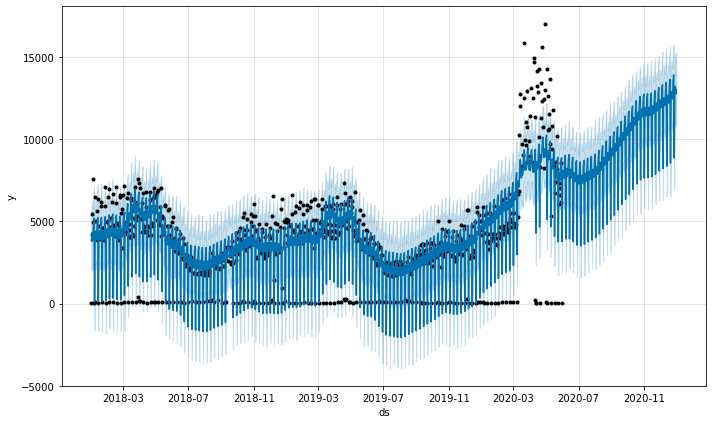

In [18]:
modelo.plot(prevision);

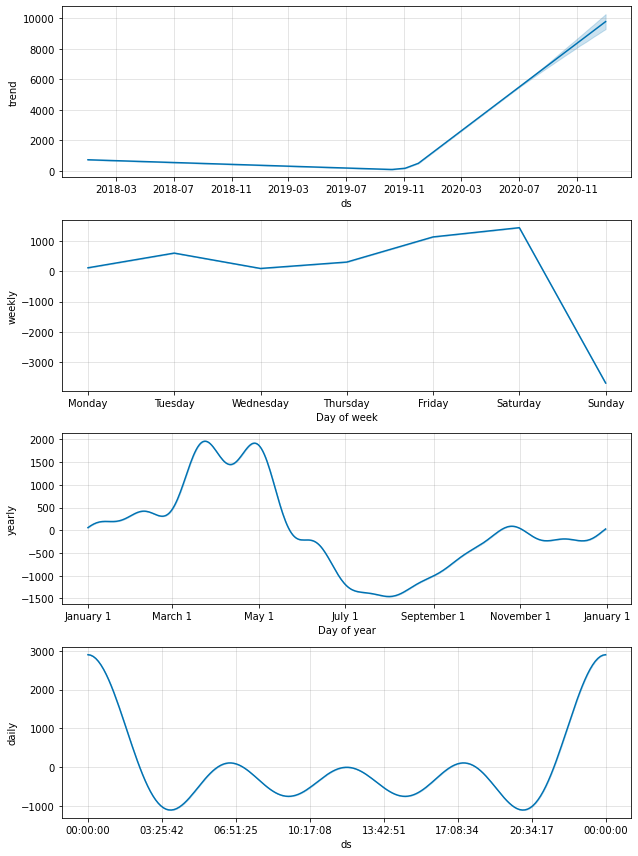

In [19]:
modelo.plot_components(prevision, weekly_start = 1);

** P ¿ Están bien nuestras predicciones ? ** Fíjate en la estacionalidad anual donde presenta un pico, ¿ ha habido alguna influencia puntual que haya podido influenciar en este cálculo ?

## 6. Mejorar nuestro modelo de previsión incluyendo algún evento especial.

Incluya una lista de holidays que sea interesante con sus distintos tags para que el modelo separe mejor que contribuciones vienen por la propia estacionalidad o por eventos externos.

Tener en cuenta todo este tipo de eventos sólo en el ámbito temporal de entrenamiento (del que tenemos datos), no lo proyectéis a futuro aún.


In [20]:
# Confinamiento COVID https://es.wikipedia.org/wiki/Confinamiento_por_la_pandemia_de_COVID-19_en_Espa%C3%B1a

semanasanta = pd.DataFrame({
  'holiday': 'semanasanta',
  'ds': pd.to_datetime(['2018-03-28','2018-03-29', '2018-03-30',
                        '2018-04-01','2018-04-02', '2019-04-18',
                        '2019-04-19','2019-04-20', '2019-04-21',
                        '2019-04-22']),
  'lower_window': 0,
  'upper_window': 1,
})
confinamiento = pd.DataFrame({
  'holiday': 'confinamiento',
  'ds': pd.to_datetime(['2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
               '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
               '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27',
               '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
               '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05',
               '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09',
               '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17',
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
               '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
               '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-20', '2020-06-21']),
  'lower_window': 0,
  'upper_window': 1,
})


In [21]:
dias_especiales = pd.concat((semanasanta, confinamiento))
dias_especiales

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
94,confinamiento,2020-06-17,0,1
95,confinamiento,2020-06-18,0,1
96,confinamiento,2020-06-19,0,1
97,confinamiento,2020-06-20,0,1


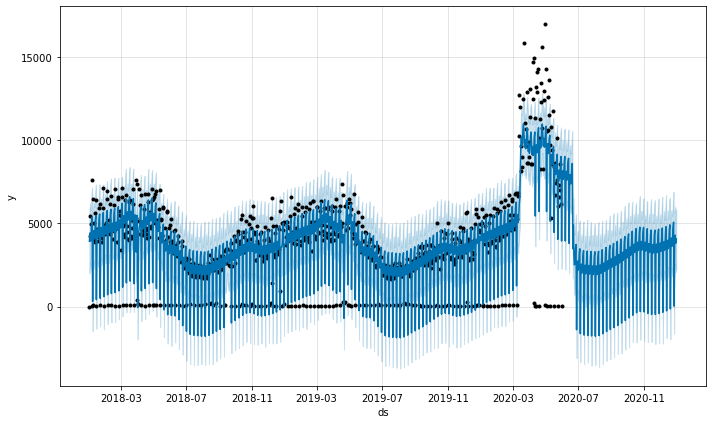

In [22]:
dias_especiales = dias_especiales.reset_index()
modelo2 = Prophet(holidays=dias_especiales,daily_seasonality=True)
prevision2 = modelo2.fit(df_datos_categorias_mejor).predict(futuro)
modelo2.plot(prevision2);

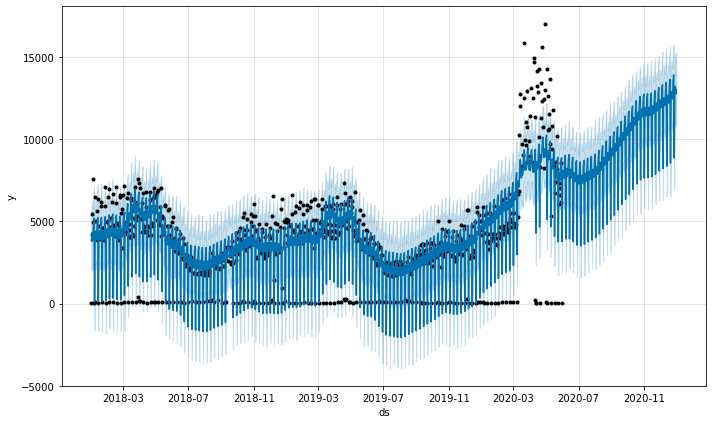

In [23]:
#Modelo anterior
modelo.plot(prevision);

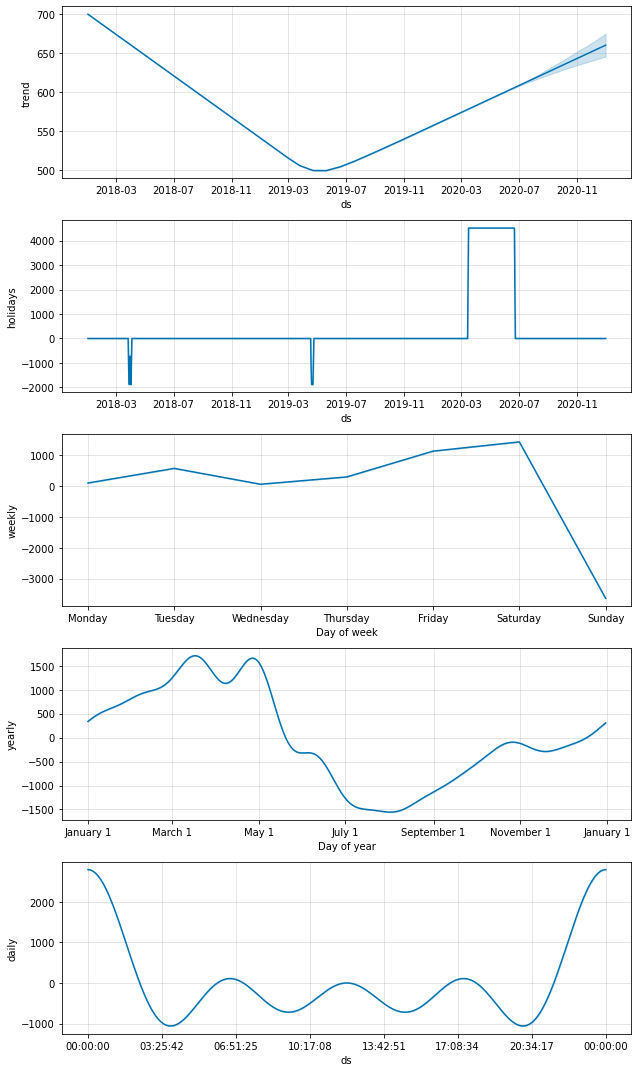

In [24]:
modelo2.plot_components(prevision2, weekly_start = 1);

## 7. Plantear distintos escenarios sobre un posible confinamiento y ver su impacto en las ventas (usando el % variación  de ventas entre trimestres)

Ya que hemos visto como el modelo se ha modificado en cuanto hemos señalado eventos externos que tenían cierta influencia sobre nuestra serie temporal se os pide que para la categoría que queráis, hagáis el entrenamiento del modelo y la predicción hasta 2021 teniendo en cuenta los efectos de todas estas variables externas y además incluirlos en vuestra predicción a futuro según distintos escenarios que tengáis en mente.

### Escenario 1 : Hay confinamiento a principios de 2021

In [25]:
#Obtenemos los datos de la tabla pivotada por trimestres y en el que se recogen las variaciones entre trimestres.
df_datos_categorias_fs=df_categorias_trimestre_pivot['Frutos secos'].reset_index()
df_datos_categorias_fs = df_datos_categorias_fs.rename(columns={'Fecha': 'ds', 'Frutos secos': 'y'})
df_datos_categorias_fs

,ds,y
0,2018-03-31,NaN
1,2018-06-30,-4.044877
2,2018-09-30,-8.328014
3,2018-12-31,27.529403
4,2019-03-31,-2.491035
5,2019-06-30,-3.631239
6,2019-09-30,-7.592919
7,2019-12-31,17.533934
8,2020-03-31,17.220868
9,2020-06-30,-16.240684


In [26]:
# Confinamiento COVID https://es.wikipedia.org/wiki/Confinamiento_por_la_pandemia_de_COVID-19_en_Espa%C3%B1a

semanasanta_2021 = pd.DataFrame({
  'holiday': 'semanasanta_2021',
  'ds': pd.to_datetime(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04','2021-04-05']),
  'lower_window': 0,
  'upper_window': 1,
})
confinamiento_inicio_2021 = pd.DataFrame({
  'holiday': 'confinamiento_inicio_2021',
  'ds': pd.to_datetime(['2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09',
               '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13',
               '2021-03-14']),
  'lower_window': 0,
  'upper_window': 1,
})

eurocopa_2021 = pd.DataFrame({
  'holiday': 'eurocopa_2021',
  'ds': pd.to_datetime(['2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14',
               '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18',
               '2021-06-19', '2021-06-20', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-26',
               '2021-06-27', '2021-06-28', '2021-06-29', '2021-06-30',
               '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-10', '2021-07-11']),
  'lower_window': 0,
  'upper_window': 1,
})


In [27]:
# pd.date_range(start='2021-06-11', end='2021-7-11')

In [28]:
dias_especiales_incio_2021 = pd.concat((semanasanta,confinamiento, confinamiento_inicio_2021,semanasanta_2021,eurocopa_2021))
dias_especiales_incio_2021

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
26,eurocopa_2021,2021-07-07,0,1
27,eurocopa_2021,2021-07-08,0,1
28,eurocopa_2021,2021-07-09,0,1
29,eurocopa_2021,2021-07-10,0,1


In [29]:
dias_especiales_incio_2021 = dias_especiales_incio_2021.reset_index()

In [30]:
modelo_2021_1 = Prophet(holidays=dias_especiales_incio_2021,daily_seasonality=True,weekly_seasonality=True)
modelo_2021_1.fit(df_datos_categorias_fs)

INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


In [31]:
#futuro = modelo_2021_1.make_future_dataframe(periods=579)
#Como la información es trimestral, generamos 6 periodos para poder predecir lo que queda de 2020 y todo el 2021
futuro = modelo_2021_1.make_future_dataframe(periods=6,freq='Q')
futuro.tail(6)

,ds
10,2020-09-30
11,2020-12-31
12,2021-03-31
13,2021-06-30
14,2021-09-30
15,2021-12-31


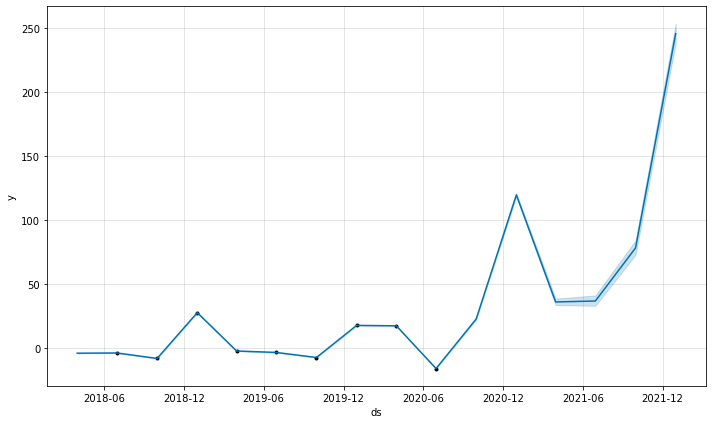

In [32]:
prevision_2021_1 = modelo_2021_1.predict(futuro)
modelo_2021_1.plot(prevision_2021_1);

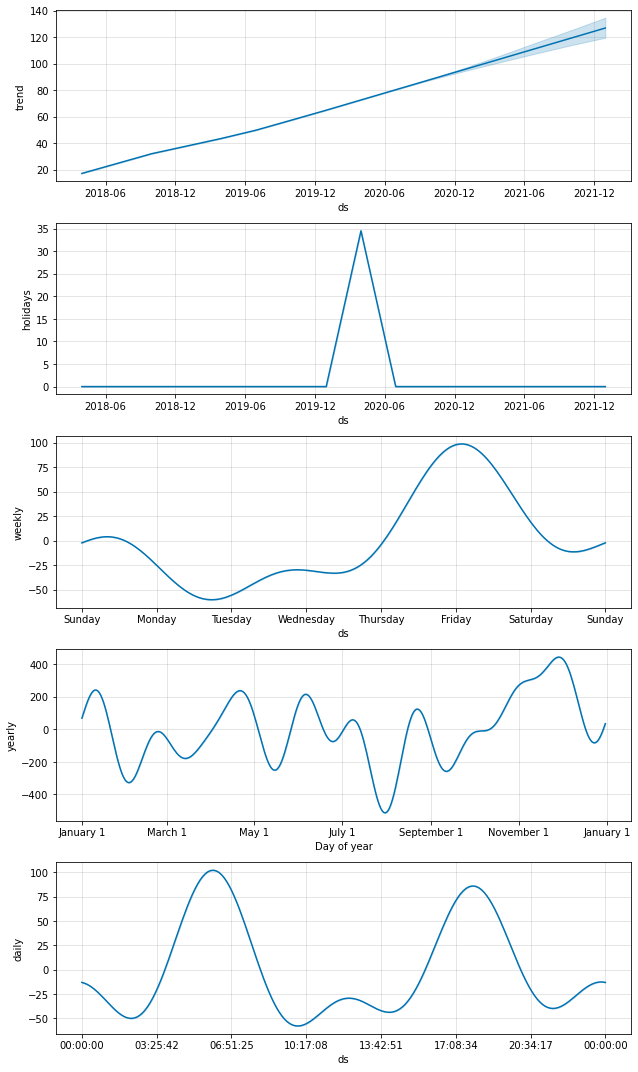

In [33]:
modelo_2021_1.plot_components(prevision_2021_1, weekly_start = 1);

### Escenario 2 : Hay confinamiento en verano de 2021 por una cepa nueva

In [34]:
confinamiento_verano_2021 = pd.DataFrame({
  'holiday': 'confinamiento_verano_2021',
  'ds': pd.to_datetime(['2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31']),
  'lower_window': 0,
  'upper_window': 1,
})

In [35]:
dias_especiales_verano_2021 = pd.concat((semanasanta,confinamiento,semanasanta_2021,eurocopa_2021,confinamiento_verano_2021))
dias_especiales_verano_2021

,holiday,ds,lower_window,upper_window
0,semanasanta,2018-03-28,0,1
1,semanasanta,2018-03-29,0,1
2,semanasanta,2018-03-30,0,1
3,semanasanta,2018-04-01,0,1
4,semanasanta,2018-04-02,0,1
...,...,...,...,...
43,confinamiento_verano_2021,2021-08-27,0,1
44,confinamiento_verano_2021,2021-08-28,0,1
45,confinamiento_verano_2021,2021-08-29,0,1
46,confinamiento_verano_2021,2021-08-30,0,1


In [36]:
modelo_2021_2 = Prophet(holidays=dias_especiales_verano_2021,daily_seasonality=True,weekly_seasonality=True)
modelo_2021_2.fit(df_datos_categorias_fs)

INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


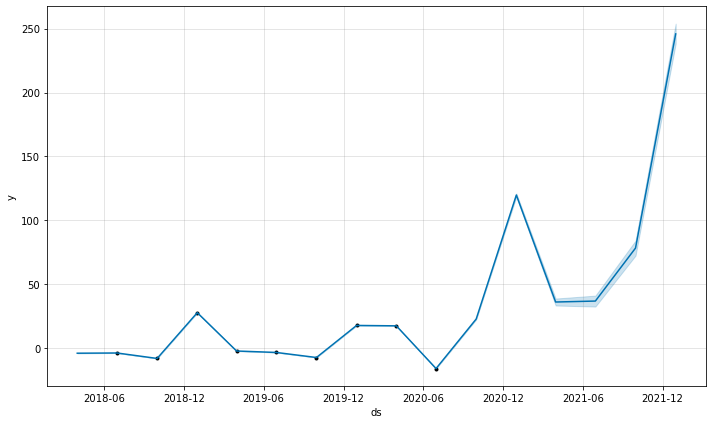

In [37]:
prevision_2021_2 = modelo_2021_2.predict(futuro)
modelo_2021_2.plot(prevision_2021_2);

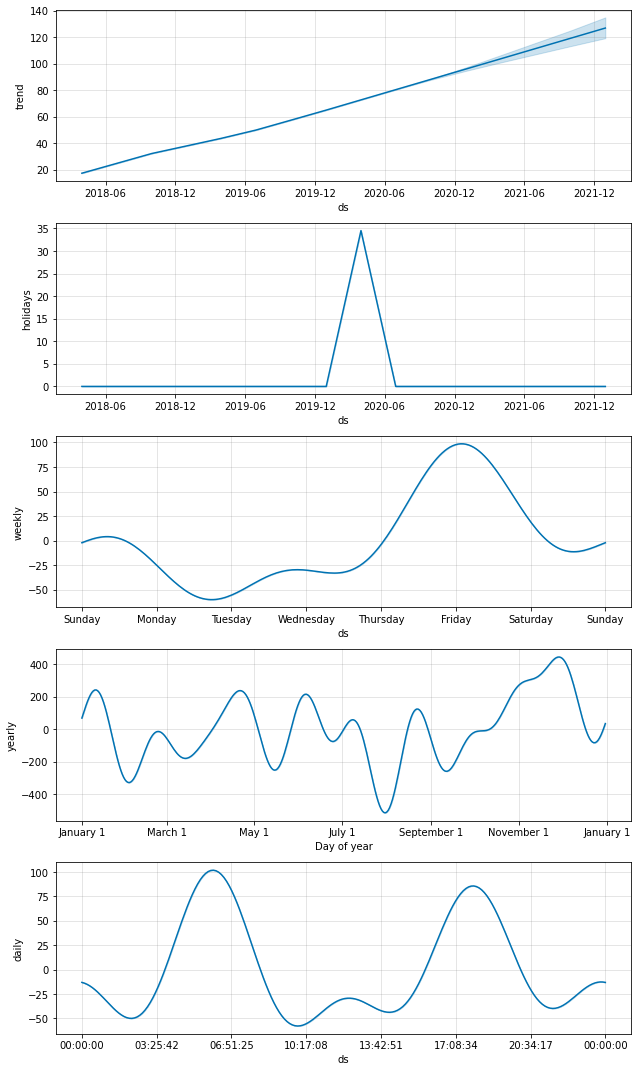

In [38]:
modelo_2021_2.plot_components(prevision_2021_2, weekly_start = 1);